In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import random

#nilearn imports
from nilearn import plotting, image, interfaces
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nilearn
import nibabel as nib
from nilearn.maskers import NiftiMasker

#sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

In [2]:
subjects = [103, 105, 106, 110, 112, 113, 115, 124, 127, 130, 
            131, 133, 138, 142, 143, 145, 157, 159, 161, 165, 
            173, 176, 177, 183, 187, 195, 200, 207, 208, 109,
            117, 140, 147, 172, 178, 180, 181, 182, 188]
data_type = 'confound'

In [3]:
# loading all beta data together

def load_beta_data(subjects, data_type):
    """
    subjects: a 1-D array of subject IDs 
    data_type: 'confound' or 'nonConfound', depending on what you are training with

    This function uses the MNI brain mask to create a uniform mask for all brain images
    """
    taskType = ['colorwheel', 'samedifferent']
    num_runs = [1, 2, 3, 4]
    
    X, y = [], []

    for subjID in subjects:
        for task in taskType:
            for run in num_runs:
                try:
                    file_path = f"~/teams/a05/group_1_data/{data_type}Beta/beta_{subjID}_{task}_{run}.nii.gz"
                    
                    beta_img = nib.load(str(file_path))
                    
                    # getting the data as an array, then flattening to 1D feature vector for model training
                    mask_img = nilearn.datasets.load_mni152_brain_mask(resolution=2, threshold=0.2)
                    masker = NiftiMasker(mask_img=mask_img, memory="nilearn_cache", memory_level=1).fit()

                    #transform the subject data to get the brain voxels
                    beta_data = masker.transform(beta_img).flatten()
                
                    X.append(beta_data)
    
                    # appending the task category to y
                    y.append(task)
                except:
                    #if there isn't a specific run, i.e. run 4
                    continue

    return np.array(X), y, masker

In [4]:
X, y, masker = load_beta_data(subjects, data_type)

/home/jancayan/.local/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


In [5]:
len(X[0])

235375

In [6]:
# Note - subjects 173B, 187B, 195B not included due to lack of preproc data
# subjects 112 and 113 are not included due to lack of events file data
# subject 145 is missing a run

print(f"Loaded {len(X)} runs")

Loaded 271 runs


In [7]:
# splitting data into 3 runs for train, 1 run for test per subject

def load_beta_data_custom_split():
    X_train, y_train = [], []
    X_test, y_test = [], []

    directories = [Path("~/teams/a05/group_1_data/confoundBeta/").expanduser(), 
    Path("~/teams/a05/group_1_data/confoundBeta/betas/").expanduser()]

    subject_runs = {}

    for directory in directories:
        beta_files = list(directory.glob("beta_*.nii.gz"))

        for file_path in beta_files:
            file_name = file_path.stem
            parts = file_name.split("_")

            subjID = parts[1]
            task = parts[2]
            run = int(parts[3].split('.')[0])

            if (subjID, task) not in subject_runs:
                subject_runs[(subjID, task)] = []
            subject_runs[(subjID, task)].append((run, file_path))

    for (subjID, task), runs in subject_runs.items():

        if len(runs) == 4:

            train_runs = runs[:3]
            test_run = runs[3]
    
            # random.shuffle(runs)
            # train_runs = sorted(runs[:3])
            # test_run = runs[3]
    
            for run, file_path in train_runs:
                beta_img = nib.load(str(file_path))
                beta_data = beta_img.get_fdata().flatten()
    
                X_train.append(beta_data)
                y_train.append(task)
    
            run, file_path = test_run
            beta_img = nib.load(str(file_path))
            beta_data = beta_img.get_fdata().flatten()
    
            X_test.append(beta_data)
            y_test.append(task)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [8]:
X_train, y_train, X_test, y_test = load_beta_data_custom_split()
print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_test)}")

Train Samples: 201, Test Samples: 67


In [9]:
unique, counts = np.unique(y_train, return_counts=True)
print('y_train counts: '), dict(zip(unique, counts))

y_train counts: 


(None, {'colorwheel': 99, 'samedifferent': 102})

In [10]:
unique, counts = np.unique(y_test, return_counts=True)
print('y_train counts: '), dict(zip(unique, counts))

y_train counts: 


(None, {'colorwheel': 33, 'samedifferent': 34})

In [11]:
# Logistic regression with random 80-20 split across all subjects/runs
def logistic_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")

    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)

    y_pred_train = logreg_model.predict(X_train)  
    train_accuracy = accuracy_score(y_train, y_pred_train) 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return logreg_model

Training on 216 samples, Testing on 55 samples
Test Accuracy: 0.9636
Train Accuracy: 1.0000
Precision: 0.9662
Recall: 0.9636


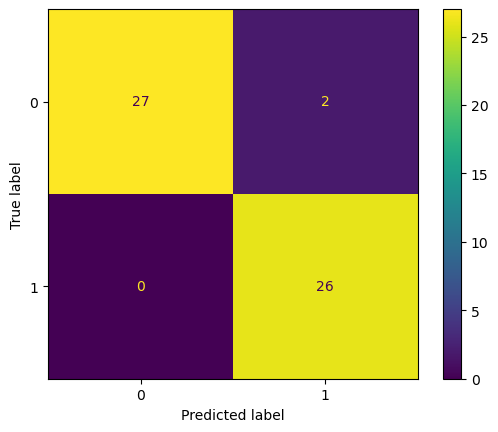

In [12]:
mod1 = logistic_reg(X, y)

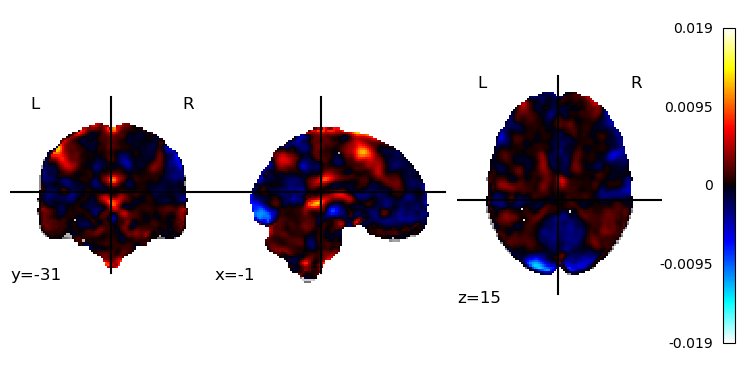

In [13]:
mod1_3d = masker.inverse_transform(mod1.coef_)
plotting.plot_stat_map(mod1_3d) #add threshholding

In [14]:
# Logistic regression with 60/20/20 train/validation/test split and hyperparameter tuning

def train_logistic_reg(X, y):

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    print(f"Training on {len(X_train)} samples, Validating on {len(X_val)} samples, Testing on {len(X_test)} samples")

    param_grid = {'C': np.logspace(-2, 2, 5), 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}

    logreg = LogisticRegression(max_iter=500)
    rand_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    rand_search.fit(X_train, y_train)

    best_model = rand_search.best_estimator_
    print(f"Best Hyperparameters: {rand_search.best_params_}")

    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return best_model, val_accuracy, test_accuracy

Training on 162 samples, Validating on 54 samples, Testing on 55 samples
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
Validation Accuracy: 0.9444
Test Accuracy: 0.9636
Precision: 0.9636
Recall: 0.9636


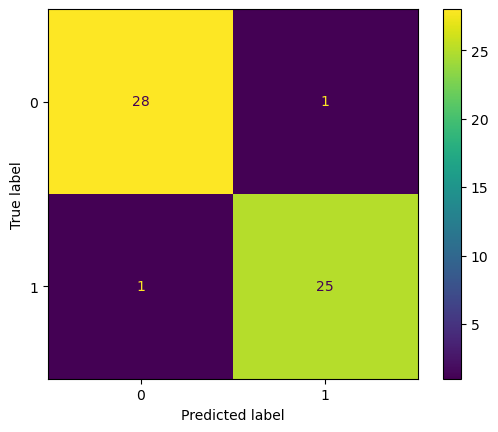

In [15]:
mod2 = train_logistic_reg(X, y)

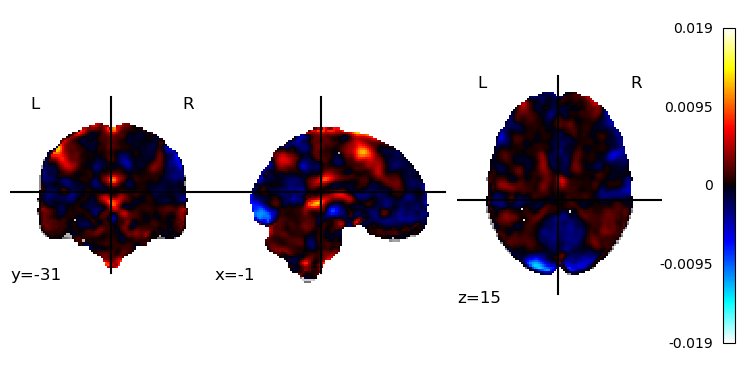

In [16]:
mod2_3d = masker.inverse_transform(mod1.coef_)
plotting.plot_stat_map(mod2_3d) #add threshholding

In [17]:
# Logistic reg model for the custom 3 runs/1 run train/test split

def logistic_reg_custom(X_train, X_test, y_train, y_test):

    print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")

    logreg_model = LogisticRegression(max_iter=1000, random_state=42)
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    y_pred_train = logreg_model.predict(X_train)  
    train_accuracy = accuracy_score(y_train, y_pred_train) 

    print(f"Model Accuracy: {accuracy:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return logreg_model

Training on 201 samples, Testing on 67 samples
Model Accuracy: 0.9851
Train Accuracy: 1.0000
Precision: 0.9855
Recall: 0.9851


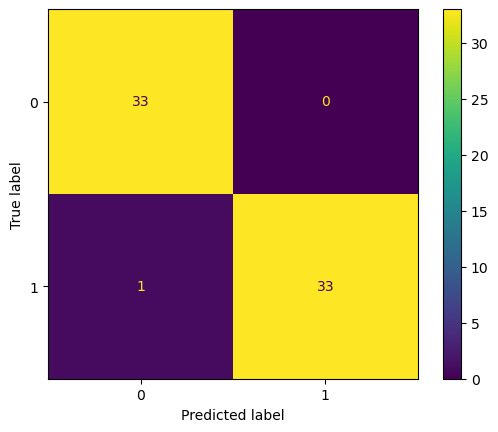

In [18]:
mod3 = logistic_reg_custom(X_train, X_test, y_train, y_test)

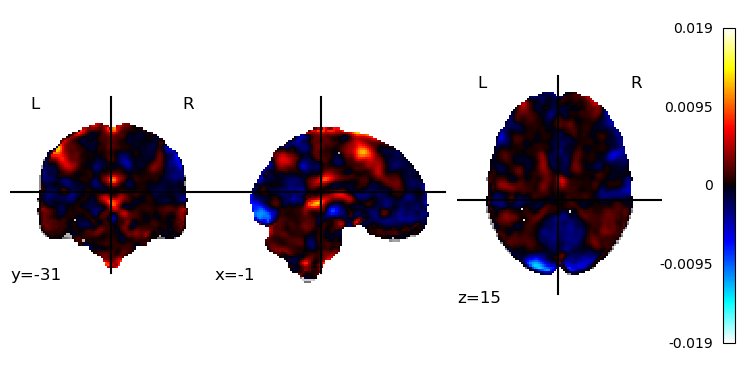

In [19]:
mod3_3d = masker.inverse_transform(mod1.coef_)
plotting.plot_stat_map(mod3_3d) #add threshholding

In [20]:
def logistic_shuffled(X_train, y_train, X_test, y_test):

    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    normal_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy before shuffling: {normal_acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    shuffled_y_train = np.random.permutation(y_train)
    shuffled_y_test = np.random.permutation(y_test)

    logreg_shuffled = LogisticRegression(max_iter=1000, random_state=42)
    logreg_shuffled.fit(X_train, shuffled_y_train)
    y_pred_shuffled = logreg_shuffled.predict(X_test)
    shuffled_acc = accuracy_score(shuffled_y_test, y_pred_shuffled)
    print(f"Accuracy after shuffling: {shuffled_acc:.4f}")

    cm = confusion_matrix(shuffled_y_test, y_pred_shuffled)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    if normal_acc > shuffled_acc + 0.2:
        print("The model is good")
    else:
        print("Overfitting or bias detected")

    return normal_acc, shuffled_acc

Accuracy before shuffling: 0.9851


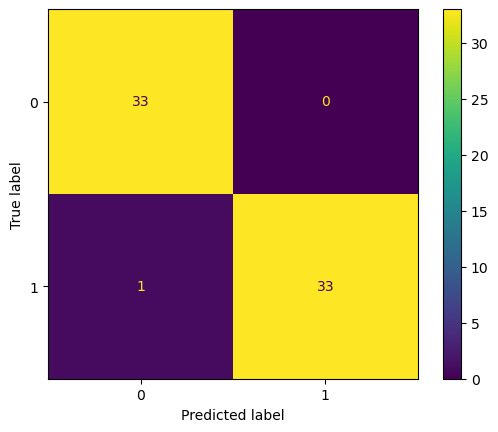

Accuracy after shuffling: 0.3881


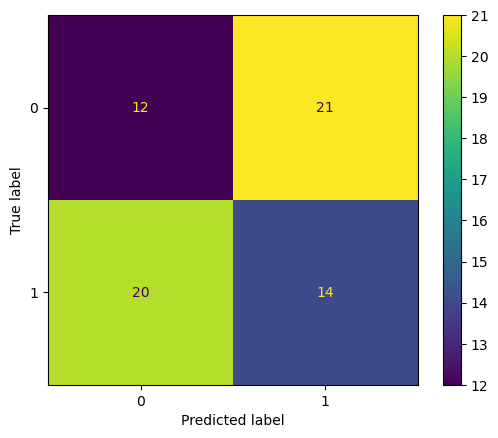

The model is good


In [21]:
normal_acc, shuffled_acc = logistic_shuffled(X_train, y_train, X_test, y_test)

In [22]:
def plot_subject_stat_maps(subjID, task1, task2, run=1):

    file_path_task1 = f"~/teams/a05/group_1_data/confoundBeta/beta_{subjID}_{task1}_{run}.nii.gz"
    file_path_task2 = f"~/teams/a05/group_1_data/confoundBeta/beta_{subjID}_{task2}_{run}.nii.gz"

    beta_img_task1 = nib.load(file_path_task1)
    beta_img_task2 = nib.load(file_path_task2)

    # cut_coords=(-65, 50) chosen because the MNI coordinates for intraparietal sulcus is 
    # x = -30, y = -65, z = 50 for the left hemisphere for the right
    # and x = 30, y = -65, z = 50 
    plotting.plot_stat_map(beta_img_task1, title=f"Subject {subjID} - Task: {task1}", 
                           vmax=2, alpha = 0.5, display_mode="yz", cut_coords=(-65, 50))
    plotting.plot_stat_map(beta_img_task2, title=f"Subject {subjID} - Task: {task2}", 
                           vmax=2, alpha = 0.5, display_mode="yz", cut_coords=(-65, 50))

    plotting.show()

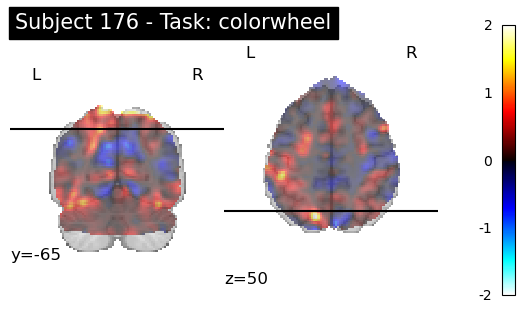

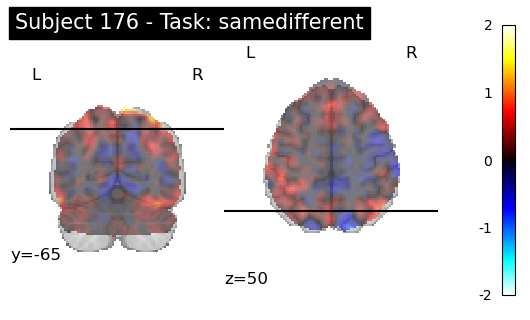

In [23]:
plot_subject_stat_maps(subjID=176, task1="colorwheel", task2="samedifferent", run=1)